
Resultados del TSP Optimizado:
--------------------------------------------------
Mejor ruta clásica: Deposito -> B -> A -> C -> Deposito
Distancia total: 13.62 km

Resultados Cuánticos:
--------------------------------------------------
Estado más frecuente: 0010
Frecuencia: 277 de 4000 mediciones (6.9%)
Ruta decodificada: Deposito -> B -> A -> C -> Deposito
Distancia de ruta cuántica: 13.62 km


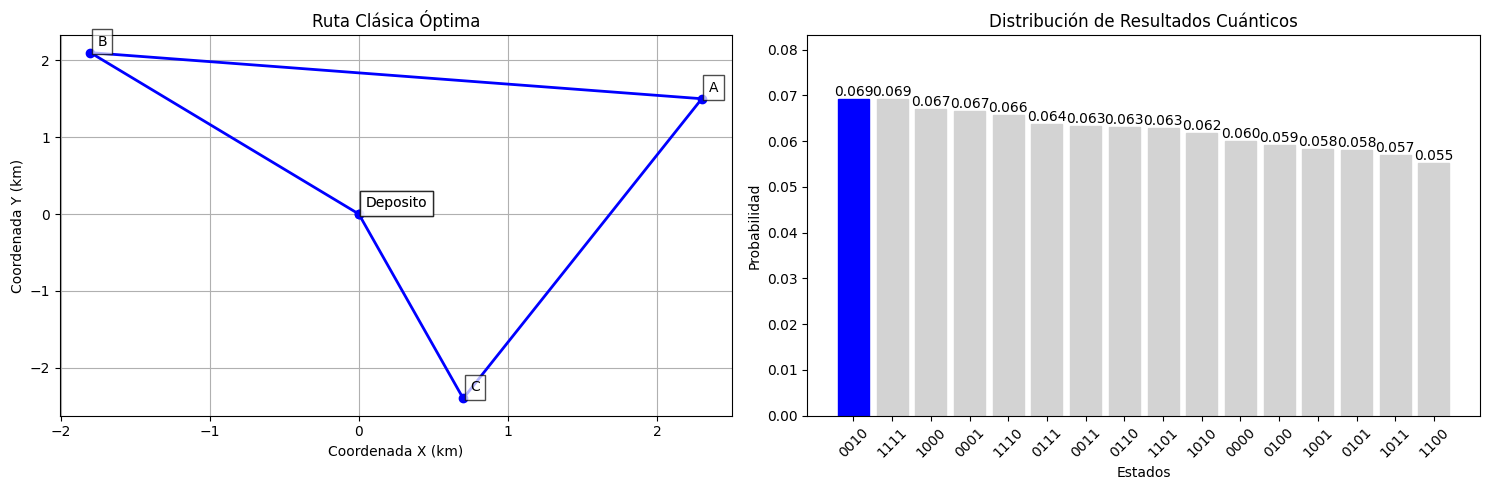

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
from itertools import permutations
import matplotlib.pyplot as plt

# Puntos de entrega
PUNTOS_ENTREGA = {
    'Deposito': (0.0, 0.0),
    'A': (2.3, 1.5),
    'B': (-1.8, 2.1),
    'C': (0.7, -2.4)
}

class SolucionadorTSP:
    def __init__(self, puntos=PUNTOS_ENTREGA):
        self.puntos = puntos
        self.rutas = list(permutations(['A', 'B', 'C']))
        self.ruta_a_binario = {
            ruta: format(i, '04b') for i, ruta in enumerate(self.rutas)
        }
        self.binario_a_ruta = {v: k for k, v in self.ruta_a_binario.items()}
        
    def calcular_distancia(self, punto1, punto2):
        return np.sqrt(
            (self.puntos[punto1][0] - self.puntos[punto2][0])**2 +
            (self.puntos[punto1][1] - self.puntos[punto2][1])**2
        )

    def obtener_distancia_ruta(self, ruta):
        ruta = list(ruta)
        ruta_completa = ['Deposito'] + ruta + ['Deposito']
        return sum(self.calcular_distancia(ruta_completa[i], ruta_completa[i+1])
                  for i in range(len(ruta_completa)-1))

    def crear_oraculo(self):
        num_qubits = 4
        oraculo = QuantumCircuit(num_qubits)
        
        # Ordenar rutas por distancia y seleccionar solo la mejor
        rutas_por_distancia = sorted(
            self.rutas,
            key=self.obtener_distancia_ruta
        )
        
        # Marcar solo la mejor ruta
        mejor_ruta = rutas_por_distancia[0]
        binario = self.ruta_a_binario[mejor_ruta]
        
        # Aplicar compuertas X para bits 0
        for i, bit in enumerate(binario):
            if bit == '0':
                oraculo.x(i)
        
        # Implementar fase negativa usando Toffoli gates en cascada
        oraculo.h(num_qubits-1)
        # Aplicar CCX en cascada
        for i in range(num_qubits-2):
            oraculo.ccx(i, i+1, num_qubits-1)
        oraculo.h(num_qubits-1)
        
        # Deshacer compuertas X
        for i, bit in enumerate(binario):
            if bit == '0':
                oraculo.x(i)
                
        return oraculo

    def crear_difusion(self):
        num_qubits = 4
        difusion = QuantumCircuit(num_qubits)
        
        # Aplicar Hadamard
        for qubit in range(num_qubits):
            difusion.h(qubit)
            
        # Aplicar X
        for qubit in range(num_qubits):
            difusion.x(qubit)
            
        # Implementar fase condicional usando CCX en cascada
        difusion.h(num_qubits-1)
        for i in range(num_qubits-2):
            difusion.ccx(i, i+1, num_qubits-1)
        difusion.h(num_qubits-1)
        
        # Deshacer X y H
        for qubit in range(num_qubits):
            difusion.x(qubit)
        for qubit in range(num_qubits):
            difusion.h(qubit)
            
        return difusion

    def crear_circuito(self):
        num_qubits = 4
        registro_q = QuantumRegister(num_qubits, 'q')
        registro_c = ClassicalRegister(num_qubits, 'c')
        circuito = QuantumCircuit(registro_q, registro_c)
        
        # Inicialización mejorada
        for qubit in range(num_qubits):
            circuito.h(qubit)
        
        # Optimizar número de iteraciones
        iteraciones = 2
        oraculo = self.crear_oraculo()
        difusion = self.crear_difusion()
        
        for _ in range(iteraciones):
            circuito = circuito.compose(oraculo)
            circuito = circuito.compose(difusion)
            # Añadir una barrera entre iteraciones para mejor separación
            circuito.barrier()
        
        circuito.measure(range(num_qubits), range(num_qubits))
        return circuito

    def ejecutar_solucion_cuantica(self):
        circuito = self.crear_circuito()
        simulador = BasicSimulator()
        # Aumentar shots para mejor estadística
        trabajo = simulador.run(circuito, shots=4000)
        return trabajo.result().get_counts()

    def decodificar_resultado(self, cadena_binaria):
        ruta = self.binario_a_ruta.get(cadena_binaria, None)
        if ruta is None:
            return ['Ruta Inválida']
        return ['Deposito'] + list(ruta) + ['Deposito']

    def resolver_clasico(self):
        mejor_ruta = min(self.rutas, key=self.obtener_distancia_ruta)
        return ['Deposito'] + list(mejor_ruta) + ['Deposito']

    def visualizar_resultados(self, ruta_clasica, conteos_cuanticos):
        fig = plt.figure(figsize=(15, 5))
        
        # Subplot para ruta clásica
        ax1 = plt.subplot(121)
        puntos = [self.puntos[punto] for punto in ruta_clasica]
        xs, ys = zip(*puntos)
        
        plt.plot(xs, ys, 'b-o', linewidth=2)
        for i, punto in enumerate(ruta_clasica):
            plt.annotate(punto, (xs[i], ys[i]), 
                        xytext=(5, 5), textcoords='offset points',
                        bbox=dict(facecolor='white', alpha=0.7))
        
        plt.title('Ruta Clásica Óptima')
        plt.xlabel('Coordenada X (km)')
        plt.ylabel('Coordenada Y (km)')
        plt.grid(True)
        
        # Subplot para resultados cuánticos
        ax2 = plt.subplot(122)
        
        total_mediciones = sum(conteos_cuanticos.values())
        conteos_ordenados = dict(sorted(conteos_cuanticos.items(), 
                                      key=lambda x: x[1], 
                                      reverse=True))
        
        estados = list(conteos_ordenados.keys())
        probabilidades = [conteo/total_mediciones for conteo in conteos_ordenados.values()]
        
        # Colorear basado en si es la solución óptima
        ruta_clasica_bin = self.ruta_a_binario[tuple(ruta_clasica[1:-1])]
        colores = ['blue' if estado == ruta_clasica_bin else 'lightgray' 
                  for estado in estados]
        
        barras = plt.bar(range(len(estados)), probabilidades)
        
        for barra, color in zip(barras, colores):
            barra.set_color(color)
        
        plt.title('Distribución de Resultados Cuánticos')
        plt.xlabel('Estados')
        plt.ylabel('Probabilidad')
        
        plt.xticks(range(len(estados)), estados, rotation=45)
        
        for i, prob in enumerate(probabilidades):
            plt.text(i, prob, f'{prob:.3f}',
                    ha='center', va='bottom')
        
        plt.ylim(0, max(probabilidades) * 1.2)
        
        plt.tight_layout()
        
        return fig

def principal():
    solucionador = SolucionadorTSP()
    
    # Solución clásica
    ruta_clasica = solucionador.resolver_clasico()
    distancia_clasica = solucionador.obtener_distancia_ruta(ruta_clasica[1:-1])
    
    print("\nResultados del TSP Optimizado:")
    print("-" * 50)
    print(f"Mejor ruta clásica: {' -> '.join(ruta_clasica)}")
    print(f"Distancia total: {distancia_clasica:.2f} km")
    
    try:
        # Solución cuántica
        conteos_cuanticos = solucionador.ejecutar_solucion_cuantica()
        mas_frecuente = max(conteos_cuanticos.items(), key=lambda x: x[1])
        ruta_decodificada = solucionador.decodificar_resultado(mas_frecuente[0])
        
        print("\nResultados Cuánticos:")
        print("-" * 50)
        print(f"Estado más frecuente: {mas_frecuente[0]}")
        mediciones = sum(conteos_cuanticos.values())
        print(f"Frecuencia: {mas_frecuente[1]} de {mediciones} mediciones ({mas_frecuente[1]/mediciones*100:.1f}%)")
        print(f"Ruta decodificada: {' -> '.join(ruta_decodificada)}")
        
        if ruta_decodificada != ['Ruta Inválida']:
            distancia_cuantica = solucionador.obtener_distancia_ruta(ruta_decodificada[1:-1])
            print(f"Distancia de ruta cuántica: {distancia_cuantica:.2f} km")
        
        fig = solucionador.visualizar_resultados(ruta_clasica, conteos_cuanticos)
        plt.show()
        
    except Exception as e:
        print(f"\nError en la ejecución cuántica: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    principal()